In [74]:
"""
==========================================
Fuzzy Control Systems: The Tipping Problem
==========================================

The 'tipping problem' is commonly used to illustrate the power of fuzzy logic
principles to generate complex behavior from a compact, intuitive set of
expert rules.

If you're new to the world of fuzzy control systems, you might want
to check out the `Fuzzy Control Primer
<../userguide/fuzzy_control_primer.html>`_
before reading through this worked example.

The Tipping Problem
-------------------

Let's create a fuzzy control system which models how you might choose to tip
at a restaurant.  When tipping, you consider the service and food quality,
rated between 0 and 10.  You use this to leave a tip of between 0 and 25%.

We would formulate this problem as:

* Antecednets (Inputs)
   - `service`
      * Universe (ie, crisp value range): How good was the service of the wait
        staff, on a scale of 0 to 10?
      * Fuzzy set (ie, fuzzy value range): poor, acceptable, amazing
   - `food quality`
      * Universe: How tasty was the food, on a scale of 0 to 10?
      * Fuzzy set: bad, decent, great
* Consequents (Outputs)
   - `tip`
      * Universe: How much should we tip, on a scale of 0% to 25%
      * Fuzzy set: low, medium, high
* Rules
   - IF the *service* was good  *or* the *food quality* was good,
     THEN the tip will be high.
   - IF the *service* was average, THEN the tip will be medium.
   - IF the *service* was poor *and* the *food quality* was poor
     THEN the tip will be low.
* Usage
   - If I tell this controller that I rated:
      * the service as 9.8, and
      * the quality as 6.5,
   - it would recommend I leave:
      * a 20.2% tip.


Creating the Tipping Controller Using the skfuzzy control API
-------------------------------------------------------------

We can use the `skfuzzy` control system API to model this.  First, let's
define fuzzy variables
"""
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [75]:
# New Antecedent/Consequent objects hold universe variables and membership
## Inputs
### Traffic Light State 
TL_State = ctrl.Antecedent(np.arange(0, 5, 0.1), 'TL_State')
TL_State['Off'] = fuzz.trapmf(TL_State.universe, [0.75, 0.75, 1.25, 1.25])
TL_State['Green'] = fuzz.trapmf(TL_State.universe, [1.75, 1.75, 2.25, 2.25])
TL_State['Yellow'] = fuzz.trapmf(TL_State.universe, [2.75, 2.75, 3.25, 3.25])
TL_State['Red'] = fuzz.trapmf(TL_State.universe, [3.75, 3.75, 4.25, 4.25])

### Distance to the Traffic Light
Distance = ctrl.Antecedent(np.arange(0, 16, 1), 'Distance')
Distance['Close'] = fuzz.trapmf(Distance.universe, [0, 0, 5, 8])
Distance['Normal'] = fuzz.trapmf(Distance.universe, [5, 8, 11, 13])
Distance['Far'] = fuzz.trapmf(Distance.universe, [11, 13, 15, 15])

## Ouput
Brake_Signal = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'Brake_Signal')
Brake_Signal['No_Brake'] = fuzz.trapmf(Brake_Signal.universe, [0, 0, 0.1, 0.2])
Brake_Signal['Moderate_Brake'] = fuzz.trimf(Brake_Signal.universe, [0.2, 0.3, 0.5])
Brake_Signal['Full_Brake'] = fuzz.trapmf(Brake_Signal.universe, [0.5, 0.8, 1, 1])

C:\Users\Andres\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


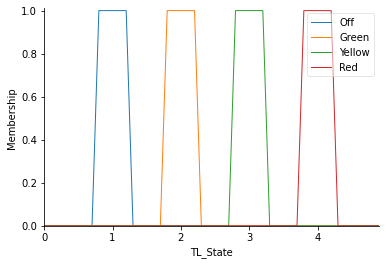

In [76]:
"""
To help understand what the membership looks like, use the ``view`` methods.
"""

# You can see how these look with .view()
TL_State.view()

C:\Users\Andres\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


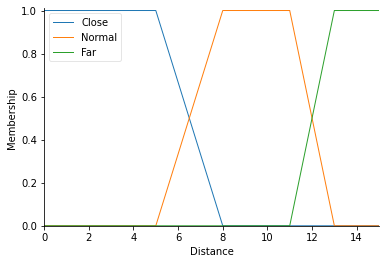

In [77]:
Distance.view()

C:\Users\Andres\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


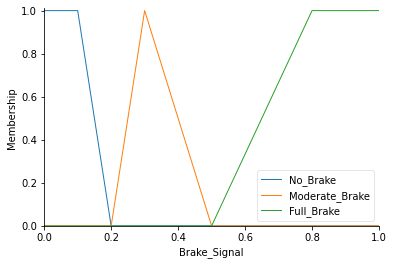

In [78]:
Brake_Signal.view()

'\n.. image:: PLOT2RST.current_figure\n'

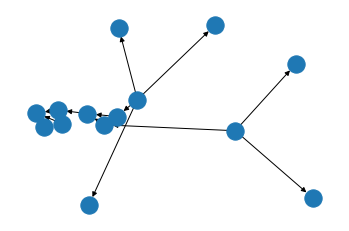

In [79]:
"""
Fuzzy rules
-----------

Now, to make these triangles useful, we define the *fuzzy relationship*
between input and output variables. For the purposes of our example, consider
three simple rules:

1. If the food is poor OR the service is poor, then the tip will be low
2. If the service is average, then the tip will be medium
3. If the food is good OR the service is good, then the tip will be high.

Most people would agree on these rules, but the rules are fuzzy. Mapping the
imprecise rules into a defined, actionable tip is a challenge. This is the
kind of task at which fuzzy logic excels.
"""

rule1 = ctrl.Rule(TL_State['Green'] & Distance['Close'], Brake_Signal['No_Brake'])
rule2 = ctrl.Rule(TL_State['Green'] & Distance['Normal'], Brake_Signal['No_Brake'])
rule3 = ctrl.Rule(TL_State['Green'] & Distance['Far'], Brake_Signal['No_Brake'])
rule4 = ctrl.Rule(TL_State['Off'] & Distance['Far'], Brake_Signal['No_Brake'])
rule5 = ctrl.Rule(TL_State['Yellow'] & Distance['Far'], Brake_Signal['No_Brake'])
rule6 = ctrl.Rule(TL_State['Red'] & Distance['Far'], Brake_Signal['No_Brake'])
rule7 = ctrl.Rule(TL_State['Off'] & Distance['Normal'], Brake_Signal['Moderate_Brake'])
rule8 = ctrl.Rule(TL_State['Yellow'] & Distance['Normal'], Brake_Signal['Moderate_Brake'])
rule9 = ctrl.Rule(TL_State['Red'] & Distance['Normal'], Brake_Signal['Moderate_Brake'])
rule10 = ctrl.Rule(TL_State['Off'] & Distance['Close'], Brake_Signal['Full_Brake'])
rule11 = ctrl.Rule(TL_State['Yellow'] & Distance['Close'], Brake_Signal['Full_Brake'])
rule12 = ctrl.Rule(TL_State['Red'] & Distance['Close'], Brake_Signal['Full_Brake'])

rule1.view()

"""
.. image:: PLOT2RST.current_figure
"""

In [80]:
"""
Control System Creation and Simulation
---------------------------------------

Now that we have our rules defined, we can simply create a control system
via: """

TL_Decision_Making = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6,
                                   rule7, rule8, rule9, rule10, rule11, rule12])

"""
In order to simulate this control system, we will create a
``ControlSystemSimulation``.  Think of this object representing our controller
applied to a specific set of cirucmstances.  For tipping, this might be tipping
Sharon at the local brew-pub.  We would create another
``ControlSystemSimulation`` when we're trying to apply our ``tipping_ctrl``
for Travis at the cafe because the inputs would be different.
"""

inference = ctrl.ControlSystemSimulation(TL_Decision_Making)

0.5944370860927154


C:\Users\Andres\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


'\n.. image:: PLOT2RST.current_figure\n\nThe resulting suggested tip is **20.24%**.\n\nFinal thoughts\n--------------\n\nThe power of fuzzy systems is allowing complicated, intuitive behavior based\non a sparse system of rules with minimal overhead. Note our membership\nfunction universes were coarse, only defined at the integers, but\n``fuzz.interp_membership`` allowed the effective resolution to increase on\ndemand. This system can respond to arbitrarily small changes in inputs,\nand the processing burden is minimal.\n\n'

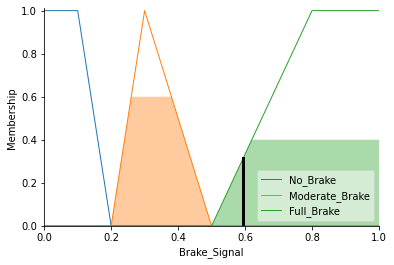

In [88]:
"""
We can now simulate our control system by simply specifying the inputs
and calling the ``compute`` method.  Suppose we rated the quality 6.5 out of 10
and the service 9.8 of 10.
"""
# Pass inputs to the ControlSystem using Antecedent labels with Pythonic API
# Note: if you like passing many inputs all at once, use .inputs(dict_of_data)
inference.input['TL_State'] = 4
inference.input['Distance'] = 6.8

# Crunch the numbers
inference.compute()

"""
Once computed, we can view the result as well as visualize it.
"""
print (inference.output['Brake_Signal'])
Brake_Signal.view(sim=inference)

"""
.. image:: PLOT2RST.current_figure

The resulting suggested tip is **20.24%**.

Final thoughts
--------------

The power of fuzzy systems is allowing complicated, intuitive behavior based
on a sparse system of rules with minimal overhead. Note our membership
function universes were coarse, only defined at the integers, but
``fuzz.interp_membership`` allowed the effective resolution to increase on
demand. This system can respond to arbitrarily small changes in inputs,
and the processing burden is minimal.

"""